# Exercise 10 warmup

We have that:

$$
\begin{align}
    (qa)^2 + (qb)^2 &= (qc)^2 \hspace{2ex} \Leftrightarrow \\
    q^2a^2 + q^2b^2 &= q^2c^2 \hspace{2ex} \Leftrightarrow \\
    q^2(a^2 + b^2) &= q^2c^2 \hspace{2ex} \Leftrightarrow \\
    a^2 + b^2 &= c^2
\end{align}
$$

Thus, if $(a, b, c)$ is a Pythagorean triplet, then $(qa, qb, qc)$ must be a Pythagorian triplet as well. 

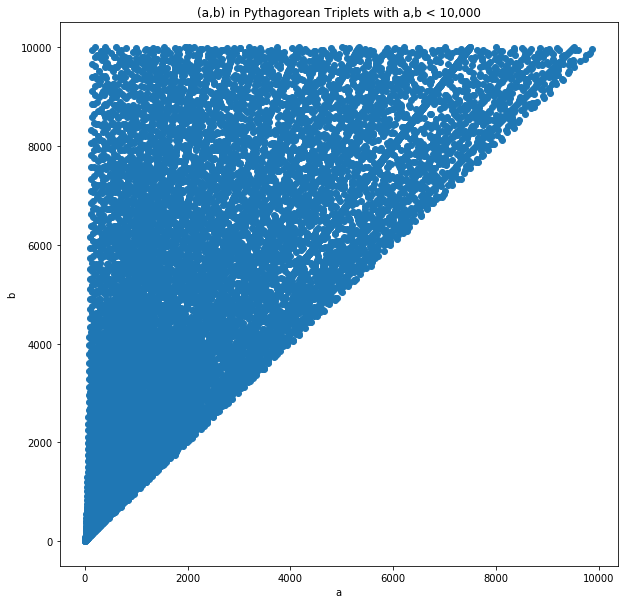

In [3]:
import math

# Define function to save a and b in Pythagorean triplets
def pythagorean_triplet(n):
    # Initialse lists
    A = []
    B = []
    
    # Loop over n
    for b in range(n):
        for a in range(1, b):
            c = math.sqrt(a**2 + b**2)
            if c % 1 == 0:
                A.append(a)
                B.append(b)
                
    return A, B

# Get all a's and b's < 10,000 in Pythagorean triplets
A, B = pythagorean_triplet(10000)

import matplotlib.pyplot as plt

# Plot a and b
plt.figure(figsize=(10,10))
plt.scatter(A, B)
plt.xlabel('a')
plt.ylabel('b')
plt.title('(a,b) in Pythagorean Triplets with a,b < 10,000')
plt.show()

# Week 10: Networks 2


Networks are mathematical representations of complex systems. We can use networks to gain various statistical insight about the system we're representing, and we can look for patterns at the meso-scale by employing *community detection* algorithms. This week we will explore the following:

* Network null models
* How to use a null model to infer the p-value of a result
* How a popular community detection algorithm works (and fails)

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
from itertools import chain
import community                # `pip install python-louvain` or `conda install -c auto python-louvain`
from netwulf import visualize   # pip install netwulf

## Exercises

### Part 1: Network null models

**What is a null model?** Null models are alternative instances of data, that are used to assess the amount of signal that is due to pure randomness. For example, you might have
measured some signal in your data, like a large number of triangles (high average local clustering coefficient)
in your network, but before you go and report that to your boss you need to answer one crucial question: How does
this result compare with a *random* one? In other words, how can you be so sure that this high number of triangles
measured is not perfectly normal even in a random network of similar origin and therefore not very special after all? The answer: **You create a null model to compare your result with!**

> Note: Null models are a concept from the general field of statistics and therefore not just specific to
networks. You can use this statistical tool anytime you need to assess how likely it is that your result is random.

The most common type of null models is one where you shuffle links in your network, while preserving the degree
sequence. Recall, that the degree sequence is a list that stores the degree of each node. So if we shuffle and
preserve the degree sequence at the same time, it means that after all the link-shuffling is done, nodes will
have new neighbors, but the same number of neighbors. In this shuffled network (the null model), if you find that
there are far fewer triangles than in your real data, then you can start to argue that your result is significant.

> Note: The term *null model* is a slight misnomer, as it is not a model per se, but rather an instance of the
data that is permuted in some way (usually under constraints, such as preservation of degree sequence), so it can
be taken to represent *randomness*. As such, there is no *model*, but rather an *instance* or simply *data*.

But that is just one comparison. What if the number of triangles in the random data – the null model – is smaller, but
not that much smaller? Can you still say your result is significant? Well, the trick (although computationally expensive
as you will come to learn) is to do MANY comparisons. 1000 is not a bad start. For each comparison, you check if
the number of triangles in your real data is bigger. After you have compared one thousand times you compute **the
fraction of times** your number of triangles in the real data was bigger than in the random data. Guess what that
number (between 0 and 1) is called? **The p-value**. And what does it communicate? **The probability that your result
is random!**

^ That's some useful statistics right there!

Please make sure you have **READ AND UNDERSTOOD** the above, as you will otherwise have a very hard time completing the
following exercises.

<br>

<br>

**Ex. 10.1.1**: The method described above works for anything you might want to measure in a network. Let's say,
instead of measuring the number of triangles, you measured the network diameter. Explain in your own words how to
assess the statistical significance (the p-value) of such a measurement, using the same null model.

**Answer:**

The *diameter* of a network is the longest shortest path in the network. 

To assess whether the diameter of a network is "special", or is different from the diameter in a null model in a statistically significant way, I could use the same method as above. First, I would shuffle the links in the network while preserving the degree sequence 1,000 times or more, and each time I would compute the diameter of the network and store it. Then, I would compare the original network diameter with each of the 1,000 null model diameters and calculate the fraction of times my network diameter is smaller (or larger) than the null model diameters. If this fraction is larger than 0.95, my diameter is significantly smaller (or larger) than a random diameter at a 5 pct. signifiance level. 

<br>

**Ex. 10.1.2**: The null model described above rewires a network while preserving the degree distribution. [Here](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html#networkx.algorithms.swap.double_edge_swap) is
implementation of it in NetworkX. In your own words, describe:
1. How it works and why it achieves randomness
without changing the degree distribution.
2. Also describe what can sometimes happen and why the desired number of swaps `nswaps` is only an upper-bound on
the number of swaps.

**Answer:**

1. The `double_edge_swap()` function swaps pairs of links/edges in the network randomly, while holding the node degrees fixed. E.g. if nodes $a$ and $b$ are linked and nodes $c$ and $d$ are linked, it swaps the links such that $a$ and $c$ are linked and $b$ and $d$ are linked.


2. Continuing the example above, it can happen that there is already a link between nodes $a$ and $c$. Then, no swap is performed in this link pair. That is why `nswaps`, which indicates the number of swaps the function should perform, is only an upper-bound of the number of swaps. 

<br>

**Ex. 10.1.3**: Load the Facebook wall-post network from last week, into a `networkx.Graph` object called `G`.
1. Measure the average local clustering coefficient (ALCC) of `G`. Print it.
2. Over 1000 iterations, measure the ALCC for `G` where, in each iteration, you have made 1000 edge swaps using 
`double_edge_swap`. Append the measured ALCC values to a list. Print the average of this list. *Note: This will
obviously take some time*.
3. Report the p-value of your result, the ALCC of the real data.
4. Make a histogram that displays the distribution of ALCC values in the null models as a histogram as well as
the ALCC of the real data as a vertical line. Comment on this result. Does it make sense?

**Answer to 10.1.3.4.:**

Figure 1 shows the histogram of the distribution average local clustering coefficients in the 1,000 null models as well as the ALCC of the real data, show as a dashed line. 


It does make sense that the average local clustering coefficient of the Facebook wall post network is significantly larger than the ALCCs of null models, where the links are placed randomly. A network's average clustering coefficient captures the degree to which the neighbours of the nodes in the network link to each other. Since we expect there to be communities in a social network like the Facebook wall post network, and the definition of a community is a group of nodes that have a higher likelihood of connecting to each other than to nodes from other communities, we expect the ALCC to be higher than in a null model.

In [ ]:
# Load the Facebook wall-post network
data = pd.read_csv(
    "facebook-wall.txt.gz",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp'])

G = nx.from_pandas_edgelist(data, 'user1', 'user2', create_using=nx.Graph)

In [ ]:
# 1. Measure the average local clustering coefficient 
alcc = nx.average_clustering(G)
print(f'Average local clustering coefficient: {alcc}')

In [ ]:
# 2. Calculate the ALCC for 1,000 null models
alcc_ = []

for i in range(1000):
    print(i)
    G_ = G.copy()
    null = nx.double_edge_swap(G_, nswap=1000, max_tries=2000)
    alcc_.append(nx.average_clustering(null))

Average of 1,000 ALCCs from null models: 0.1045466402726918
p-value of ALCC of real data: 0.00


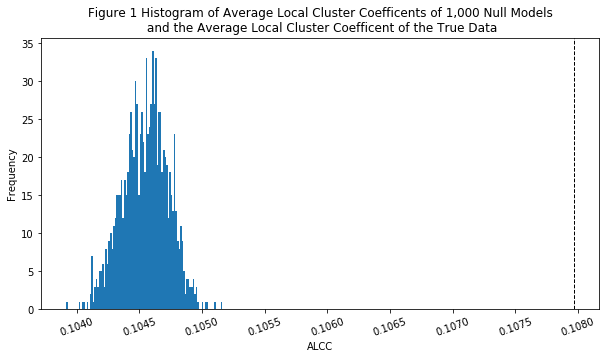

In [40]:
# 2. Print average of list
avg = np.mean(alcc_)
print(f'Average of 1,000 ALCCs from null models: {avg}')

# 3. Calculate the p-value
p = []
for i in alcc_:
    if i > alcc:
        p.append(1)
    elif i <= alcc:
        p.append(0)

print(f'p-value of ALCC of real data: {np.mean(p):.2f}')

# 4. Histogram with the ALCC of the real data
plt.figure(figsize=(10,5))
plt.hist(alcc_, density=0, bins=100) 
plt.ylabel('Frequency')
plt.xlabel('ALCC')
plt.xticks(rotation=20)
plt.title("Figure 1 Histogram of Average Local Cluster Coefficents of 1,000 Null Models"
          "\n and the Average Local Cluster Coefficent of the True Data")
plt.axvline(alcc, color='k', linestyle='dashed', linewidth=1)

plt.show()

### Part 2: Community detection

Communities are little lumps of nodes in a network that are unusually strongly connected. Your family is a community, and your friend group from work or university is another community. While there is no one true definition of what a community is, there are many many different methods and algorithms for finding them. Here we will work with one of the most popular ones: [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity). The following exercises will walk you through the fundamentals of this method, and finally have you apply it to the network you used last week.

#### The modularity function

> **Ex. 10.2.1**: Assume you have a network where nodes and links tend to form lumps here and there. Imagine you now reach for your pen, and start labeling these nodes with group names (or ids) that feel appropriate according to how they are lumped together. If your partition is "good", nodes that are connected in groups should intuitively have the same label, while nodes that are distant and disconnected should have different labels. Modularity is a function that can be used to measure, by this logic, *how good* your partition is. It is in technical terms a *utility function*, and it looks like this:
> <br><br>
> $$ Q = \dfrac{1}{2m}\sum_{ij}{\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)}.$$
> <br>
> Your job in this problem is to explain this equation. When I look at daunting math, I find it calming to try and read it as if it were code. Since all math can be implemented in code, all math can be broken into parts, where each part does a seperate thing. Answer each question below seperately:
1. In code, a sum, $\sum$, is like a `for` loop, where in every iteration you increment a variable. In the equation for modularity the little $ij$ subscript tells us what the sum is looping over (like `for ij in sumloop`). But what is $ij$?
2. In each iteration of the sum, the delta function $\delta(c_i, c_j)$ is used, where $c_i$ is the community label of node $i$. The delta function is a very simple program that returns 0 if the two input values are different and 1 if they are they same. How would you implement the delta function in code? What is it used for in the modularity equation?
3. Inside the sum we use the term $\frac{k_ik_j}{2m}$ as our *null model*. $k$ is the degree sequence (so $k_i$ is the degree of node $i$) and $m$ is the sum of all link weights. Explain what this null model measures. Could we have used other null models?
4. The sum subtracts the null model from $A_{ij}$ and adds the result to its final value if the delta function evaluates to 1. What is the point of only summing over this difference when the delta function is 1?
5. The sum term is normalized by $2m$. Why exactly $2m$?
6. Summarize your insight gained from answering the above questions. In your own words, explain how the modularity function works. Use 1-3 sentences.


**Answer:**

1. $ij$ is the id's of two nodes, node $i$ and node $j$, so the sum sums over all combination of nodes , $ij$, in the network.  


2. I would implement the delta function in code in the this way:

        def delta_func(c1, c2):
            if c1==c2:
                delta=1
            elif c1!=c2:
                delta=0
            return delta
   
   In the modularity eqution, the delta function is used to exclude any pair of nodes that are not in the same community from the sum.
   
   
3. The null model measures the expected weight of a link between node $i$ and node $j$ in a network, where the links are placed randomly. I guess we could have used other null models, for example the degree-preserving null model:

   $$
   \frac{k_ik_j}{2L},
   $$
   
   where $L$ is the total number of links in the network. 
   
   
4. $A_{ij}$ equals the weight of the link between node $i$ and node $j$ or 0 if there is no link. So, the difference is only added to the sum if:

    1. Node $i$ and node $j$ are in the same community, i.e. $\delta(c_i, c_j)=1$
    
    2. The weight of the link between node $i$ and $j$ in the real network is different from the weight of the link in the null model , i.e. $A_{ij}-\frac{k_ik_j}{2m}\neq 0$
    
    So, the sum reflects the degree to which there are more or less links inside the communities compared to the null model. Since the aim of modularity function is to measure the quality of community partitions, it would not make sense to include the difference for nodes not in the same community, i.e. when $\delta(c_i, c_j)=0$. 
    

5. It makes sense to normalise it by $m$, which is the sum of the all weights of links in the network, and I think it is also normalised by 2, because the difference for each link is added to the sum twice, one for $A_{ij}$ and one for $A_{ji}$. 


6. The modularity function works by computing the sum of the difference between the actual link weight and the expected link weight if the network were randomly wired, and it does so for all pairs of nodes in the same community for all communities in a network. The sum is normalised so the maximum value of the modularity function is 1. Hence, the modularity of a network reflects to what degree the nodes in the communities are linked and thus how good the community partition is. 

> **Ex. 10.2.2**: Implement the modularity function. Write a Python function that takes as input an adjacency matrix and a label vector, and returns the modularity. Compute and print the modularity for the ones given below. The correct result is 0.122.

In [ ]:
A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def modularity(A, c):
    """Compute modularity for a labeled network.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float
    """
    # Your beautiful code goes here
    
    # Initialise sum
    sum = 0
    
    N = A.shape[0]
    m = A.sum()/2
    
    for i in range(N):
        k_i = A[i,:].sum() # Degree of node i
        
        for j in range(N):
            k_j = A[:,j].sum() # Degree of node j
            
            # Delta function
            if c[i]==c[j]:
                delta=1
            elif c[i]!=c[j]:
                delta=0
                
            # Calculate difference
            diff = A[i,j]-k_i*k_j/(2*m)
            
            # Add difference to sum
            sum += diff*delta/(2*m)
            
    return sum

mod = modularity(A, c)
print(f'The modularity is: {mod}')

> **Ex. 10.2.3**: The example labeling, `c`, was not optimal. Find the optimal one and print its modularity score.

>*Hint: Either just try a bunch of different label combinations or visualize the network so you can see what is optimal. Using pen and paper here is no shame.*

In [ ]:
# Plot the adjencency matrix as the network
fig = plt.figure(figsize=(5, 5))
rows, cols = np.where(A == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=50)
plt.show()

# Compute the modularity for the most obvious partition (looking at the plot)
c1 = [1, 1, 1, 0, 0, 0]
print(f'Modularity score of optimal partition: {modularity(A, c1)}')

#### Finding the best communities

OK, so we are now able to evaluate the quality of a partition. But how do we find the best partition? Modularity gives us a way to measure *how good* our partition is, but it does not tell us how to find the best one. For that we need some sort of algorithm. The *Louvain method* is that algorithm.

It works in the following steps:
1. Set every node to be its own community (initiate `c = [0, 1, 2, 3, 4, 5]`).
2. Compute the modularity.
3. Now pick a random node.
    1. For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    2. If any of those relabelings led to an increase in modularity, choose the relabeling with the greatest increase.
4. Repeat 2-3 until modularity ceases to increase for any relabelings.

In [ ]:
def put(array, index, value):
    arr_ = array.copy()
    arr_[index] = value
    
    return arr_

def louvain(A, max_iter=100, max_no_improve=10):

    # 1. Set every node to be its own community
    N = A.shape[0]
    c = [i for i in range(N)]
    no_improve = 0

    # 2. Compute modularity
    mod = modularity(A, c)
    
    # Loop over maximum number of iterations
    for _ in range(max_iter):
        
        # Break if there have been no improvements for more than max_no_improve iterations
        if no_improve > max_no_improve:
            break
        
        # Initialise the list of changes in modularity 
        change_mod = []
        
        # 3. Choose random node
        i = np.random.randint(A.shape[0])

        # 3.A. Compute change in modularity when changing to every neighbour's community
        js = np.where(A[i,:] == 1)[0]
        for j in js:
            c_ = c.copy()
            mod_new = modularity(A, put(c_, i, j))
            change_mod.append(mod_new - mod)
        
        # 4. If no improvement, add to sum of iterations without improvements and continue
        if max(change_mod)<=0:
            no_improve += 1
            continue
        
        # 3.B. If improvement, choose relabeling with greatest increase
        else:
            no_improve = 0
            j_star = js[np.argmax(change_mod)]
            c = put(c, i, c_[j_star])
            mod = modularity(A, c)
            
    return c

> **Ex. 10.2.BONUS**: Implement the Louvain method, and show that it gives the labeling for `A`. A cool portfolio project for your Github account here!

In [ ]:
c2 = louvain(A)
print(f'Community partition found with Louvain: {c2}')
print(f'Modularity of the community partition: {modularity(A, c2)}')
print('')
print(f'Community partition found with by inspecting plot: {c1}')
print(f'Modularity of the community partition: {modularity(A, c1)}')

#### Communication communities on Facebook

Now let's work with some real data. Whip out the network you created **last week**, we will be using that again. Apply again the **threshold** you created in **Ex. 9.2.4**.

In [ ]:
# Defining function to slice up data with custom time bounds
def slice_it_up(data, t0, t1):
    
    # Subset of the pandas dataframe
    data_t = data.loc[data.timestamp.between(t0, t1)]

    # Count the number of times each link occurs and store that in a new 'weight' column
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

    # Create a `nx.DiGraph` from this dataframe
    G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight')
    
    return G_t

# Create aggregated Facebook wall post network for the last 365 days of the data
t0_ = data.timestamp.max() - 86400 * 365  # Lower bound of time-slice (here: 365 days before last wall post)
t1_ = data.timestamp.max()                # Upper bound of time-slice

G_t_ = slice_it_up(data, t0_, t1_)

# Thresholding
print(f'Number of nodes before thresholding: {len(G_t_.nodes())}')
print(f'Number of edges before thresholding: {len(G_t_.edges())}')

# Remove singletons
G_t_.remove_nodes_from(list(nx.isolates(G_t_))) # Removes nothing as there are no singletons

# Thresholding on edge weight
# I filter the network on edge weights, since the edge weights count the number of interactions between two people, 
# so removing low-weight edges removes weak interactions.
weight_list = list(G_t_.edges.data('weight'))
weight = [w for u,v,w in weight_list]
weight_threshold = np.percentile(weight, q = 50) # I remove all edges with weight below the 50th percentile (weight <= 1)

print("")
print(f'Weight threshold: {weight_threshold}') 

too_low = [(u,v) for u,v,w in weight_list if w <= weight_threshold]
G_thr = G_t_.copy()
G_thr.remove_edges_from(too_low)

print(f'Number of nodes after weight thresholding: {len(G_thr.nodes())}')
print(f'Number of edges after weight thresholding: {len(G_thr.edges())}')

# Thresholding on node degree
# I use node degree as threshold, since the degree count the number of links the node has to other nodes, 
# so removing low-degree nodes removes weakly connected nodes
deg_dict = dict(G_thr.degree)
deg = list(deg_dict.values())

threshold = np.percentile(deg, q = 85) # I remove all nodes with degree below the 80th percentile (degree <= 4)

print("")
print(f'Degree threshold: {threshold}') 

too_low = {k:v for k, v in  deg_dict.items() if v <= threshold}
G_thr.remove_nodes_from(list(too_low.keys()))

print(f'Number of nodes after curtailing: {len(G_thr.nodes())}')
print(f'Number of edges after curtailing: {len(G_thr.edges())}')

> **Ex. 10.2.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

**Answer:**

There are a lot of small communities and a few very large!

In [ ]:
# Find communities in Facebook wallpost network
comm_dict = community.best_partition(G_thr)

In [ ]:
# Get the list of communities
comm_list = []
for key, comm in comm_dict.items():
    comm_list.append(comm)

# Get the number of nodes in each community
comm_count = Counter(comm_list)
comm_count
comm, cnt = zip(*comm_count.items())

# Plot the distribution of community sizes
plt.figure(figsize=(10,10))
plt.hist(cnt, density=0, bins=50) 
plt.ylabel('Frequency')
plt.xlabel('Community size')
plt.xticks(rotation=20)
plt.title("Figure 3 Distribution of Community Sizes in Facebook Wall Post Network")

plt.show()

> **Ex. 10.2.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://netwulf.readthedocs.io/) are the `netwulf` docs. Fiddle around with the layout a little it always makes the network look nicer.*

**Answer:**


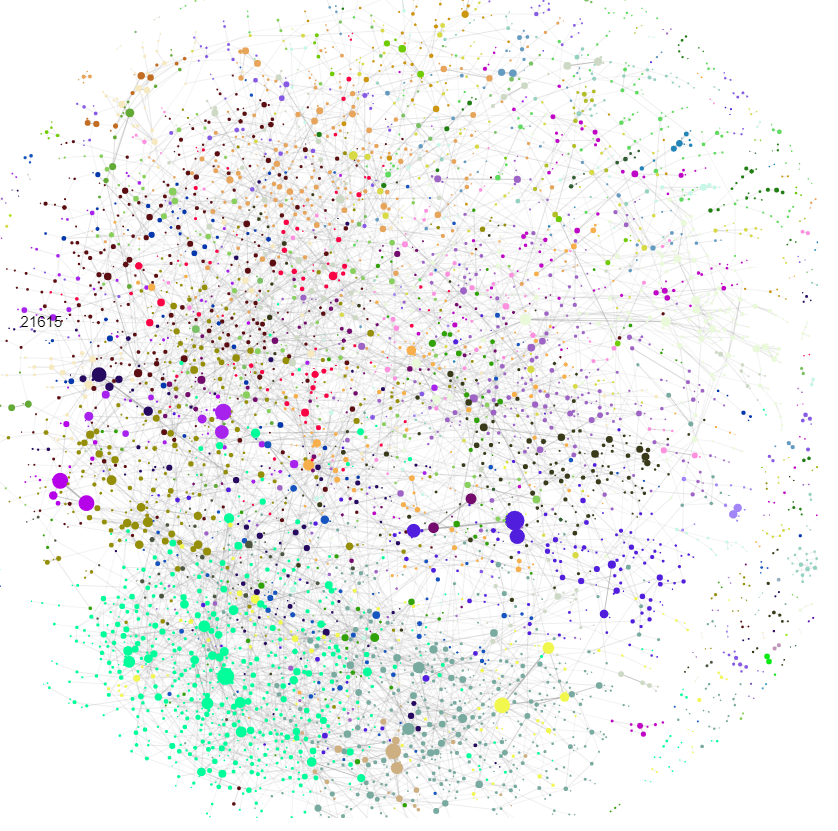

In [ ]:
# Add communities as node attribute, so visualize colours the nodes 
nx.set_node_attributes(G_thr, comm_dict, 'group')

# Visualise the network and communities in it
visualize(G_thr)

> **Ex. 10.2.6:** Maybe the communities you observed in the previous exercise were not as pretty as you were hoping.
Admittedly, the Facebook wallpost network is not the most modular network anyway, but still it examplifies a serious
problem with the Modularity score as a utility function for community detection. Can you explain what this problem is,
and why it becomes increasingly severe as the network grows larger?
>
> *Hint: It has something to do with the null model that Modularity uses*.

**Answer:**

One limitation to using modularity maximization is that merging two small otherwise distinct communities will increase the modularity. This is because the change in the modularity, $M$, when merging communities $A$ and $B$ is:

$$
\Delta M_{AB} = \frac{m_{AB}}{m} - \frac{k_A k_B}{2 m^2} = \frac{1}{m}\left( m_{AB} - \frac{k_A k_B}{2 m} \right),
$$

where $m_{AB}$ is the sum of the weight of the links (I think) that connect the nodes in community A with total degree $k_A$ to the nodes in community B with total degree $k_B$. When $A$ and $B$ are small communities, they have low degrees, since the total degree of a community is the total number of links in that community. So, even though there only are few links between community $A$ and $B$, the change in modularity, $\Delta M_{AB}$, can still be positive. 

> *Final note: There are many other community detection algorithms out there. Check out the [NetworkX docs](https://networkx.github.io/documentation/stable/reference/algorithms/community.html)
for some easy-to-use alternatives to Modularity. Also you may want to have a look at [Infomap](https://mapequation.github.io/infomap/python/)
especially if you are working with networks where links represent flow (like transactions, exchange, citations, hyperlinks, etc). It usually gives amazing results.*